<a href="https://colab.research.google.com/github/Custardwh1pp/GoogleColab_DL/blob/main/NFLCompe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ベースライン] 第2回データ分析コンペティション：NFL Draft Prediction

　本ノートブックでは、「スポーツパフォーマンステストおよび選手情報をもとに、NFLドラフト指名の有無（Drafted）を予測する」タスクのベースラインモデルを構築します。

　ベースラインモデルとは、与えられた機械学習タスクに対して、まず最初に構築されるシンプルなモデルであり、今後のモデル開発・性能向上の出発点となるものです。

　本ノートブックを上から順番に実行していけば、正常に提出できる予測ファイルが作成されます。

## 目次
1. セットアップ
2. データ読み込み
3. データの分析・EDA
4. 前処理
5. ベースラインモデル
6. 仮説と特徴量エンジニアリング
7. 提出ファイル作成
8. 今後の展望

## 1. セットアップ

In [ ]:
# Google Driveのマウント（Colab上で自分のデータにアクセスするための設定です）
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標

## 2. データ読み込み

In [ ]:
# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '/content/drive/My Drive/GCI/'

train = pd.read_csv(PATH + 'train2.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test2.csv')    # テスト用データの読み込み

　まず初めに、データのサイズを確認してみましょう。

In [ ]:
print('Train:', train.shape)
print('Test:', test.shape)

Train: (2781, 16)
Test: (696, 15)


　訓練データのデータ数は2781、変数は16、テストデータのデータ数は696、変数は15であることが分かりました。  
　ここで、テストデータの変数が1つ少ないのは、予測対象である目的変数が無いからです。  

　次に、訓練データの初めの5データを見てみましょう。

In [ ]:
train.head()

,Id,Year,Age,School,Height,Weight,Sprint_40yd,Vertical_Jump,Bench_Press_Reps,Broad_Jump,Agility_3cone,Shuttle,Player_Type,Position_Type,Position,Drafted
0,0,2011,21.0,Lehigh,1.9050,140.160042,5.39,59.69,29.0,251.46,7.91,4.94,offense,offensive_lineman,OG,1.0
1,1,2011,24.0,Abilene Christian,1.8288,87.089735,4.31,101.60,16.0,332.74,NaN,NaN,offense,backs_receivers,WR,1.0
2,2,2018,21.0,Colorado St.,1.8542,92.986436,4.51,91.44,10.0,309.88,6.95,4.37,offense,backs_receivers,WR,1.0
3,3,2010,21.0,East Carolina,1.9304,148.778297,5.09,76.20,39.0,254.00,8.12,4.71,defense,defensive_lineman,DT,1.0
4,4,2016,21.0,California,1.8796,92.079251,4.64,78.74,NaN,281.94,7.13,4.20,offense,backs_receivers,WR,1.0


　pandasのDataFrameは.info()を使用することで、詳細な情報を確認できます。

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                2781 non-null   int64  
 1   Year              2781 non-null   int64  
 2   Age               2346 non-null   float64
 3   School            2781 non-null   object 
 4   Height            2781 non-null   float64
 5   Weight            2781 non-null   float64
 6   Sprint_40yd       2636 non-null   float64
 7   Vertical_Jump     2227 non-null   float64
 8   Bench_Press_Reps  2060 non-null   float64
 9   Broad_Jump        2200 non-null   float64
 10  Agility_3cone     1811 non-null   float64
 11  Shuttle           1869 non-null   float64
 12  Player_Type       2781 non-null   object 
 13  Position_Type     2781 non-null   object 
 14  Position          2781 non-null   object 
 15  Drafted           2781 non-null   float64
dtypes: float64(10), int64(2), object(4)
memory

## 3. データの分析・EDA

　**EDA（探索的データ分析）**は、モデル構築の前にデータの構造や特徴を把握するための重要なステップです。

　この段階では、データに含まれる傾向やパターン、外れ値、欠損値、分布の偏りなどを明らかにします。たとえば、ある変数に極端な値があったり、特定のカテゴリにデータが偏っていたりすることがあります。こうした特徴を把握することで、予測に悪影響を及ぼす要因や、有効な特徴量を見つけることができます。

　EDAを行うことで、「欠損値によって学習が進まない」「外れ値の影響でモデルが不安定になる」といった問題を事前に発見し、対処できます。これにより、後工程での手戻りを減らし、効率的な前処理や特徴量設計が可能になります。

　また、EDAで得た知見は、その後のモデル設計やパラメータ調整にも役立ちます。機械学習コンペティションなどでは、最終的なスコア向上にもつながる重要なプロセスです。

　まずは欠損値を確認しておきましょう。機械学習を用いたデータ分析に取り組む上で欠損値の確認は必須となっています。なぜなら、ほとんどの機械学習モデルは欠損値を含むデータに対して学習や予測ができず、エラーとなってしまうからです。

In [ ]:
train.isnull().sum()

,0
Id,0
Year,0
Age,435
School,0
Height,0
Weight,0
Sprint_40yd,145
Vertical_Jump,554
Bench_Press_Reps,721
Broad_Jump,581


In [ ]:
test.isnull().sum()

,0
Id,0
Year,0
Age,115
School,0
Height,0
Weight,0
Sprint_40yd,29
Vertical_Jump,143
Bench_Press_Reps,184
Broad_Jump,147


　「Age」「Sprint_40yd」「Vertical_Jump」「Bench_Press_Reps」「Broad_Jump」「Agility_3cone」「Shuttle」列に欠損値があることが分かりました。これらは後で対処することとします。  

　次にドラフト選出された選手の数を見てみましょう。

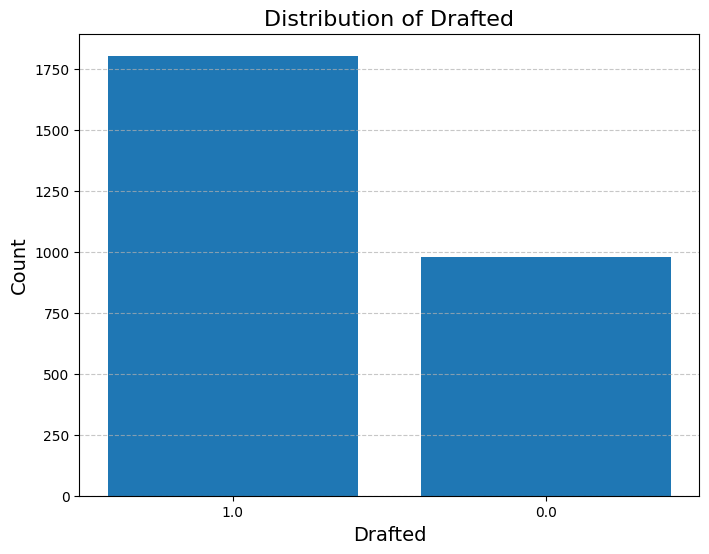

In [ ]:
drafted_counts = train['Drafted'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(drafted_counts.index.astype(str), drafted_counts.values)
plt.title('Distribution of Drafted', fontsize=16)
plt.xlabel('Drafted', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

　「Drafted」列が1である選手の方が0である選手より多いことが分かりました。割合を見てみましょう。

In [ ]:
drafted_percentage = train['Drafted'].value_counts(normalize=True) * 100

print(f"Percentage of 0: {drafted_percentage.get(0, 0):.2f}%")
print(f"Percentage of 1: {drafted_percentage.get(1, 0):.2f}%")

Percentage of 0: 35.17%
Percentage of 1: 64.83%


　ドラフト選出されなかった選手は約35%、ドラフト選出された選手は約65%いることが分かりました。

　その他の特徴量についてもEDAしていきます。まずは「Id」「Drafted」列を除く数値データについて可視化してみましょう。

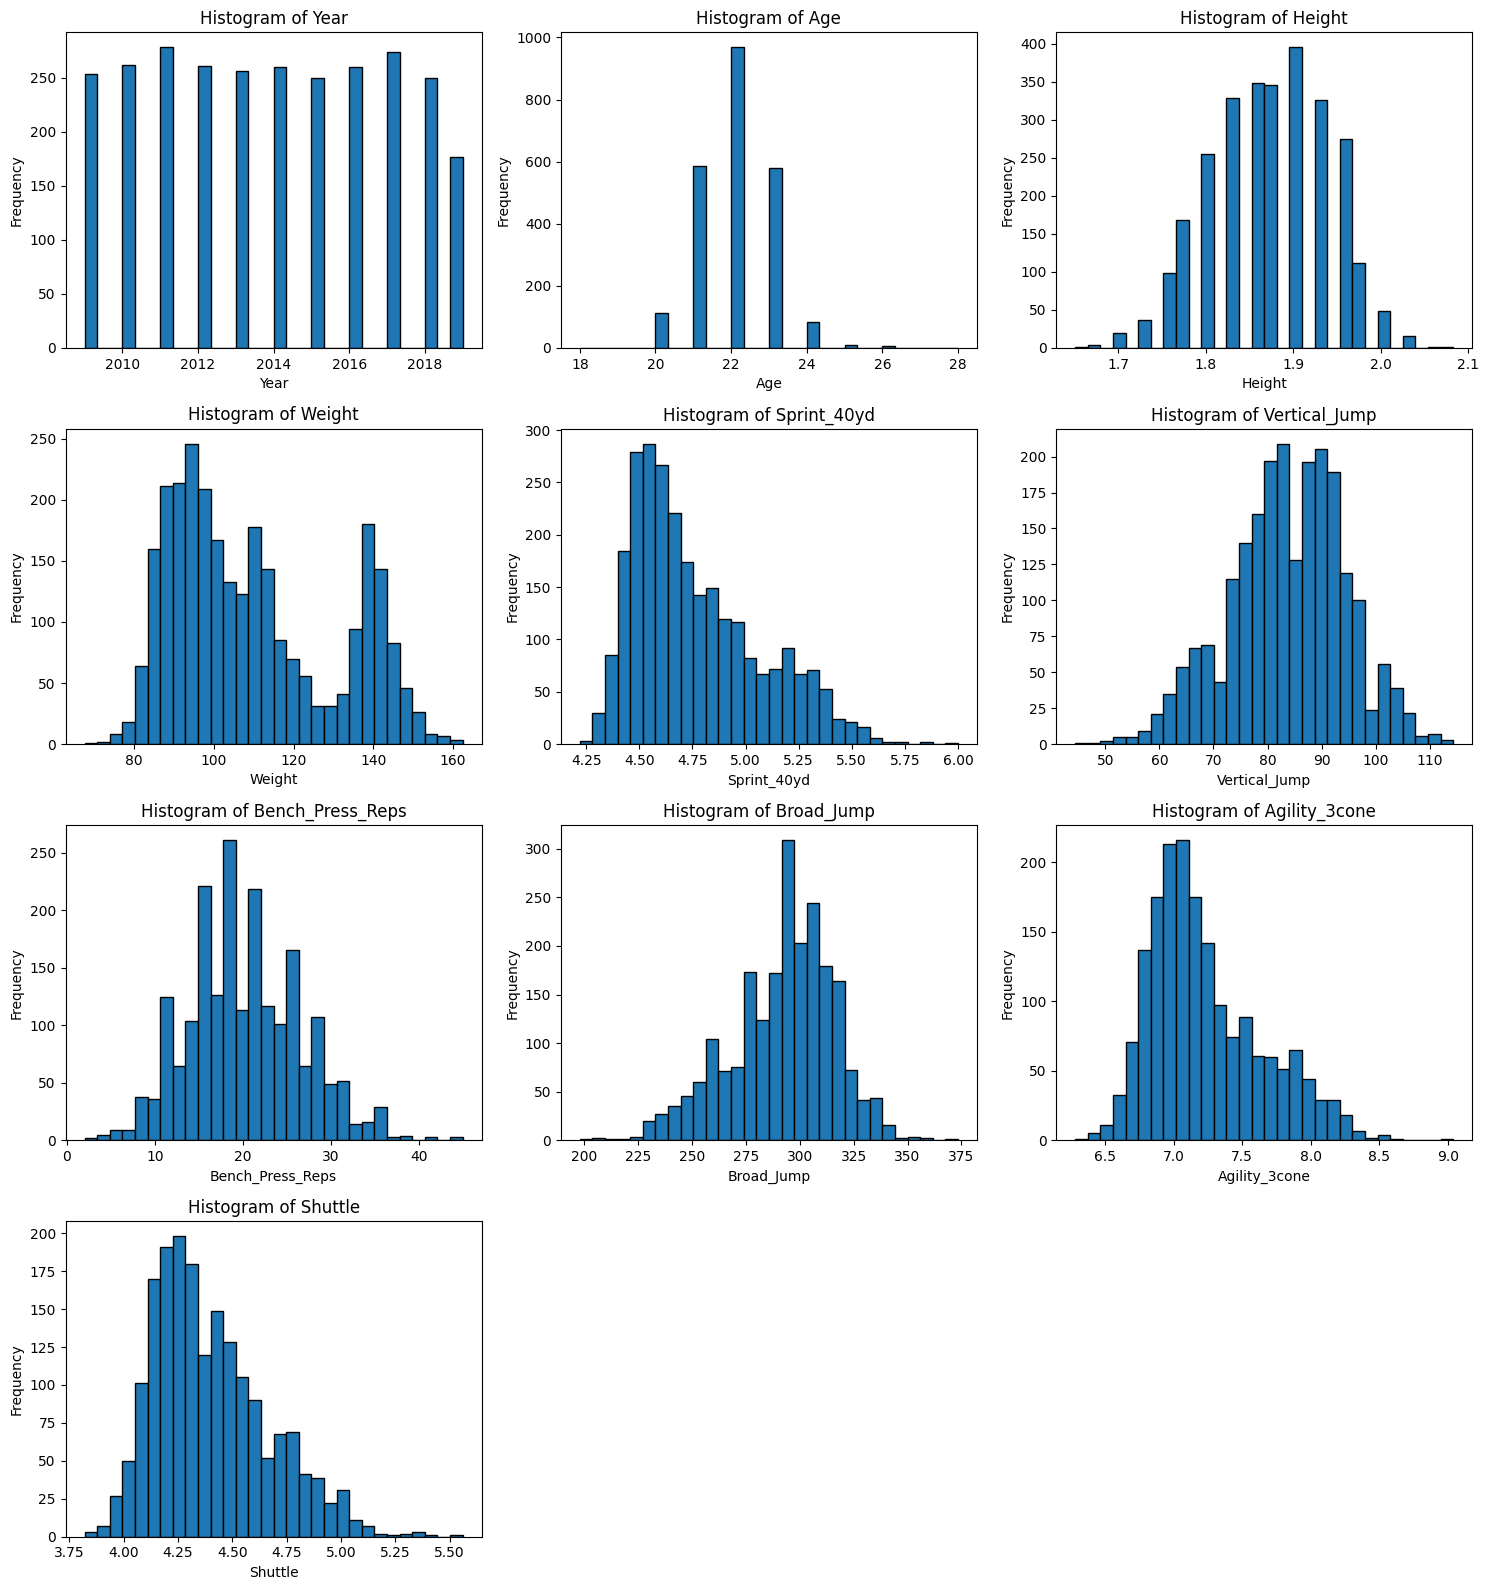

In [ ]:
# 数値列だけを取り出す（Id, Drafted列は除く）
numeric_cols = train.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop(['Id', 'Drafted'])

# プロット
num_cols = len(numeric_cols)
cols = 3
rows = (num_cols + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(train[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

　数値データの相関行列をヒートマップで確認してみましょう。

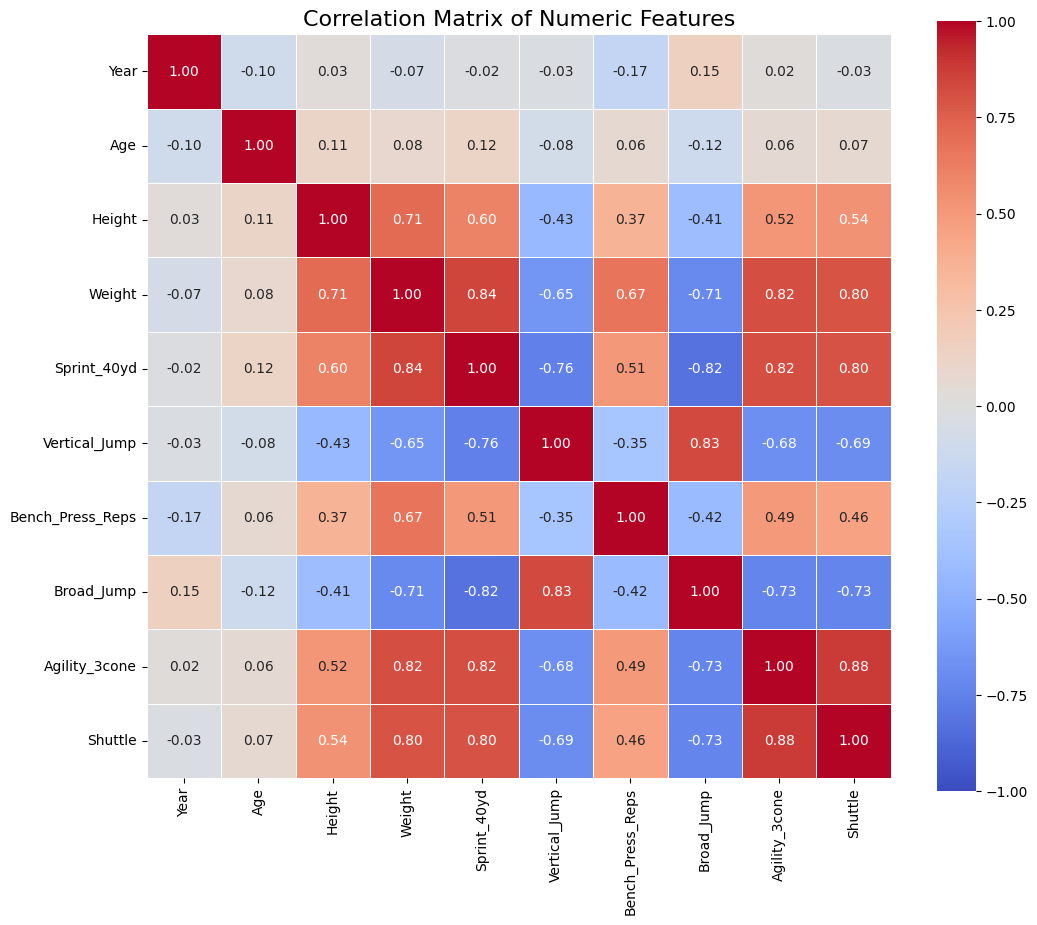

In [ ]:
# 数値列だけを取り出す（Id, Drafted列は除く）
numeric_cols = train.select_dtypes(include=['number']).drop(['Id', 'Drafted'], axis=1)

# 相関行列を計算
corr_matrix = numeric_cols.corr()

# ヒートマップをプロット
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)

plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()

　「Agility_3cone」列と「Shuttle」列の相関係数は0.88であり、強い正の相関関係があることが分かります。これらのスポーツテストでは、似た筋肉や動作が使われている可能性が考えられます。

　一方、「Sprint_40yd」列と「Broad_Jump」列の相関係数は-0.82で、強い負の相関関係が見られました。どちらも主に脚の力を使う種目であるため、通常はスコアが比例する（正の相関になる）と予想されますが、実際には逆の関係が見られています。この理由を探るため、「Sprint_40yd」列を可視化してみます。


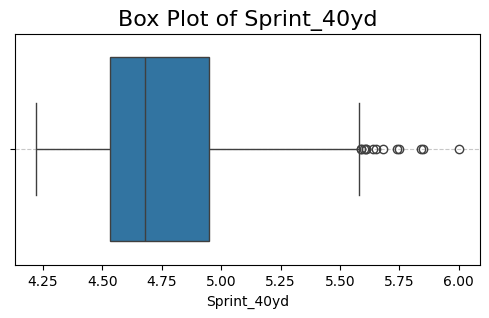

In [ ]:
# 箱ひげ図を描画
plt.figure(figsize=(6, 3))
sns.boxplot(x=train['Sprint_40yd'])

plt.title('Box Plot of Sprint_40yd', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

　可視化されたグラフを見ると、「Sprint_40yd」列の値はおおよそ4.25から6.00の範囲に分布していることがわかります。この数値はスコアではなく実際の走行タイムである可能性が高そうです。40ヤード（約36メートル）を走るタイムとして、中央値が約4.7秒であるのは妥当です。

　つまり、「Sprint_40yd」列の値が小さいほど速く走れたことを意味し、 数値が小さい＝パフォーマンスが高い という点で、他の 数値が大きいほど良い スコアとは逆の関係になっていたのです。

 データを可視化することで、「なぜ負の相関があるのか？」という疑問を解決することができました。

　次は、カテゴリデータについて可視化してみましょう。

In [ ]:
# カテゴリデータを抽出
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

# 各列の水準数を取得
levels_count = {col: train[col].nunique() for col in categorical_cols}

for col, count in levels_count.items():
    print(f"{col}: {count} levels")


School: 236 levels
Player_Type: 3 levels
Position_Type: 7 levels
Position: 20 levels


　Schoolは水準数が236とかなり多く、可視化すると潰れて見づらいのでここでは可視化しません。

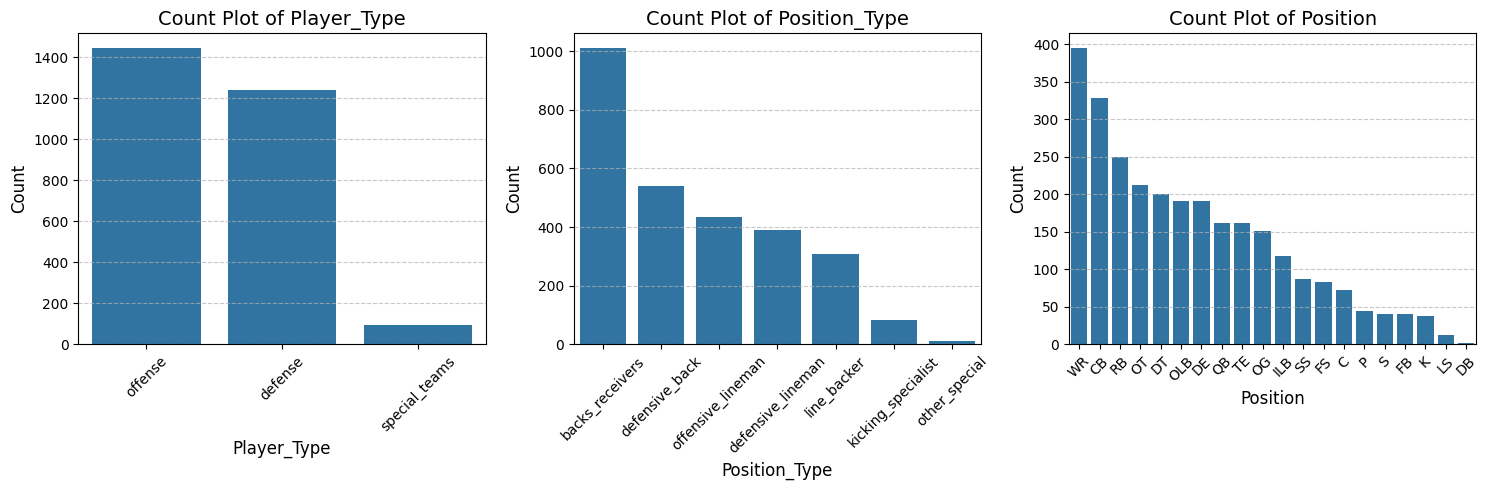

In [ ]:
# カテゴリデータ（object型またはcategory型）を抽出し、School列を除外
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('School')

# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数でカウントプロット
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=train, order=train[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

　水準によってデータ数に大きな差があるのが分かりました。例えば「Player_Type」列については、「special_teams」のデータ数がかなり少ないことが分かります。

　次に、カテゴリデータについて、各水準の「Drafted列」の平均値を可視化してみましょう。この可視化を行うことで、どのポジションの選手がドラフトされやすいのかを視覚的に理解することができます。

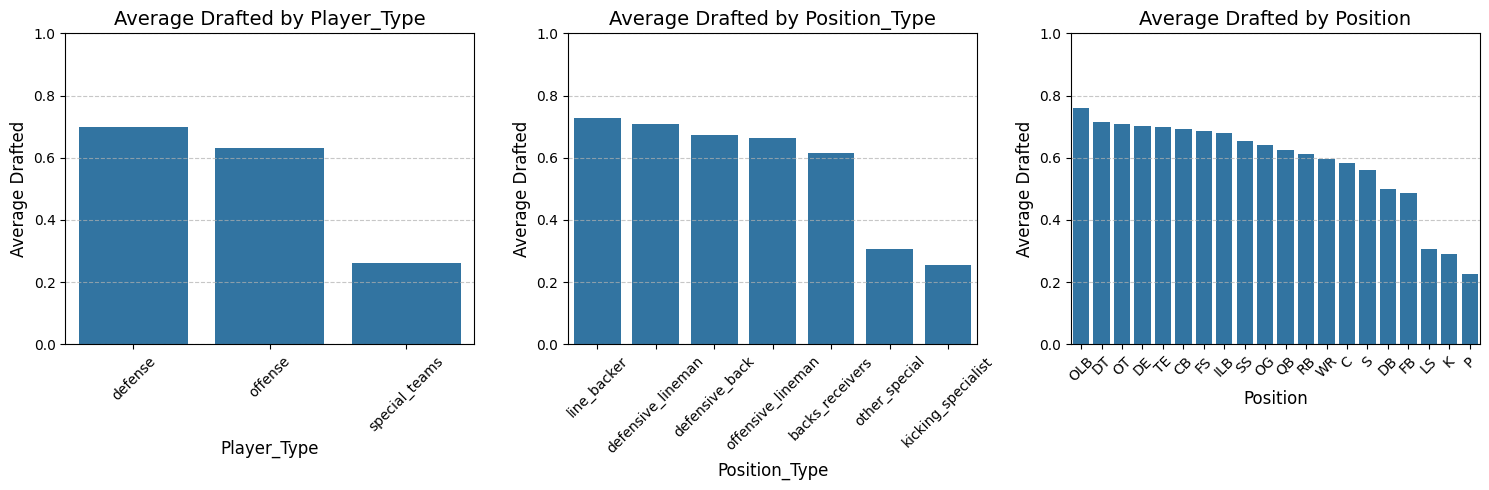

In [ ]:
# カテゴリ変数（object型またはcategory型）を抽出し、School列を除外
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('School')

# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数ごとに Drafted 列の平均を棒グラフで描画
for i, col in enumerate(categorical_cols):
    mean_values = train.groupby(col)['Drafted'].mean().sort_values(ascending=False)
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axes[i])
    axes[i].set_title(f'Average Drafted by {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Average Drafted', fontsize=12)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


　「Player_Type」列が「special_teams」である選手は他の選手と比べてドラフト選出される割合がかなり低いことが分かります。  
　また、「Position_Type」列が「other_special」「kicking_specialist」である選手、「Position」列が「LS」「K」「P」である選手もドラフト選出される割合が低いことが分かります。

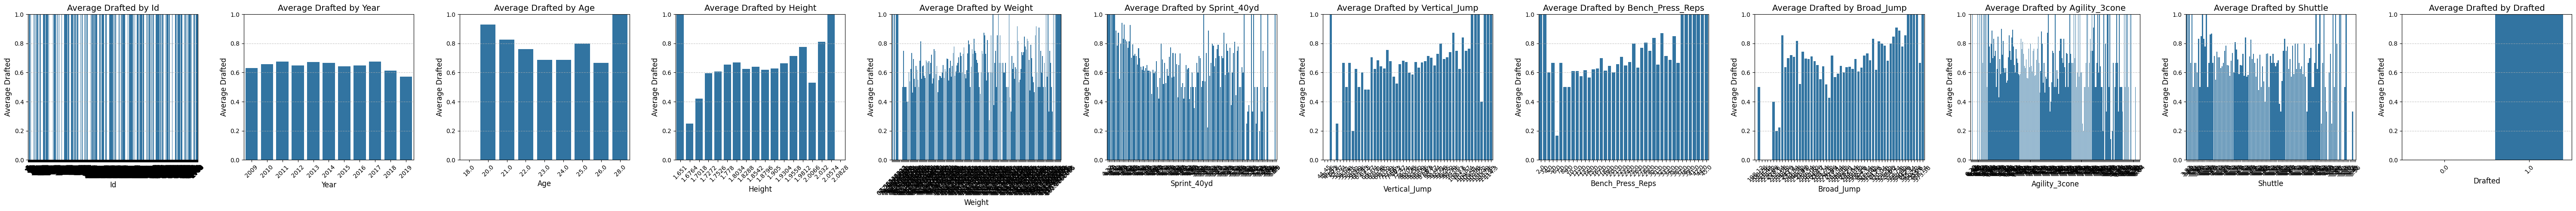

In [ ]:
# カテゴリ変数（number型）を抽出
number_cols = train.select_dtypes(include=['number']).columns

# グラフ描画準備
num_cols = len(number_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数ごとに Drafted 列の平均を棒グラフで描画
for i, col in enumerate(number_cols):
    mean_values = train.groupby(col)['Drafted'].mean().sort_values(ascending=False)
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axes[i])
    axes[i].set_title(f'Average Drafted by {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Average Drafted', fontsize=12)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 4. 前処理

　欠損補完、エンコーディングを行います。  
　本ノートブックでは、水準数が比較的多いカテゴリデータを特徴量から外すことにします。つまり、ここでは「School」列（水準数: 236）を削除します。（※「School」列の値が「Drafted」列の値に影響することも考えられます。より深く追求する際に特徴量に含めてみましょう。）また、「Id」列はドラフトの選出に関係がないと予想されるため、削除します。

In [ ]:
# 使わない列の削除
submission = test[['Id']].copy()
train = train.drop(columns=["Id", "School","Year"])
test = test.drop(columns=["Id","School","Year"])

「Age」「Sprint_40yd」「Vertical_Jump」「Bench_Press_Reps」「Broad_Jump」「Agility_3cone」「Shuttle」列に欠損値があります。本ノートブックでは、これらを平均値で補完します。

In [ ]:
# 平均で補完する対象の列
cols_to_fill = ['Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# train の平均で train/test 両方を補完
for col in cols_to_fill:
    mean_value = train[col].mean()
    train[col] = train[col].fillna(mean_value)
    test[col] = test[col].fillna(mean_value)

In [ ]:
#年齢欠損値処理
print("Ageの欠損値補完と欠損フラグの追加を開始します...")

# 補完対象の列
col_to_fill = 'Age'

# まず、欠損フラグ列を作成します
# isna() または isnull() で欠損しているかどうかを真偽値で取得し、astype(int) で 0/1 に変換
train[f'{col_to_fill}_is_missing'] = train[col_to_fill].isna().astype(int)
test[f'{col_to_fill}_is_missing'] = test[col_to_fill].isna().astype(int)

print(f"'{col_to_fill}_is_missing' フラグ列を作成しました。")

# その後、元のAge列を補完します
mean_value_age = train[col_to_fill].mean()
train[col_to_fill] = train[col_to_fill].fillna(mean_value_age)
test[col_to_fill] = test[col_to_fill].fillna(mean_value_age)

print(f"'{col_to_fill}' 列を平均値 ({mean_value_age:.2f}) で補完しました。")

print("Ageの欠損値処理が完了しました。")

# 変更を確認
# display(train[['Age', 'Age_is_missing', 'Drafted']].head())
# display(train[train['Age_is_missing'] == 1][['Age', 'Age_is_missing', 'Drafted']].head())

Ageの欠損値補完と欠損フラグの追加を開始します...
'Age_is_missing' フラグ列を作成しました。
'Age' 列を平均値 (22.00) で補完しました。
Ageの欠損値処理が完了しました。


最頻値で補完

In [ ]:
# 欠損値を最頻値で補完する対象の列
# Age, Sprint_40yd, Vertical_Jump, Bench_Press_Reps, Broad_Jump, Agility_3cone, Shuttle に欠損値がありました。
# これらの列を最頻値で補完します。

# train/test データフレームを結合し、一括で処理できるようにします
# ただし、'Drafted' 列は train にしかないので、train からは 'Drafted' 列を除外します
train_without_drafted = train.drop(columns=['Drafted'])
all_data = pd.concat([train_without_drafted, test], axis=0)

cols_to_fill_mode = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                     'Broad_Jump', 'Agility_3cone', 'Shuttle']

# 各列の最頻値を計算し、欠損値を補完
for col in cols_to_fill_mode:
    # 最頻値は mode()[0] で取得できます (mode() は複数の最頻値がある場合があるためリストで返します)
    if not all_data[col].mode().empty:
        mode_value = all_data[col].mode()[0]
        all_data[col] = all_data[col].fillna(mode_value)
        print(f"'{col}' 列の欠損値を最頻値 ({mode_value}) で補完しました。")
    else:
        print(f"'{col}' 列には最頻値が計算できませんでした (すべての値がNaNなど)。補完をスキップします。")


# 補完後のデータをtrainとtestに分割し直す
train_imputed_mode = all_data.iloc[:len(train)].copy()
test_imputed_mode = all_data.iloc[len(train):].copy()

# train_imputed_mode に元の 'Drafted' 列を戻す
train_imputed_mode['Drafted'] = train['Drafted'].values # インデックスを考慮せず値のみコピー

# 元の train と test データフレームを更新 (任意: 新しいデータフレームとして保持しても良いです)
train = train_imputed_mode
test = test_imputed_mode

# 欠損値がなくなったか確認
print("\n最頻値補完後のtrainの欠損値:")
print(train.isnull().sum())
print("\n最頻値補完後のtestの欠損値:")
print(test.isnull().sum())

'Age' 列の欠損値を最頻値 (22.0) で補完しました。
'Sprint_40yd' 列の欠損値を最頻値 (4.5) で補完しました。
'Vertical_Jump' 列の欠損値を最頻値 (83.82) で補完しました。
'Bench_Press_Reps' 列の欠損値を最頻値 (19.0) で補完しました。
'Broad_Jump' 列の欠損値を最頻値 (304.8) で補完しました。
'Agility_3cone' 列の欠損値を最頻値 (7.07) で補完しました。
'Shuttle' 列の欠損値を最頻値 (4.28) で補完しました。

最頻値補完後のtrainの欠損値:
Age                 0
Height              0
Weight              0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
Player_Type         0
Position_Type       0
Position            0
Drafted             0
dtype: int64

最頻値補完後のtestの欠損値:
Age                 0
Height              0
Weight              0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
Player_Type         0
Position_Type       0
Position            0
dtype: int64


K-NN近傍法により補完

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# 補完対象の列は元々欠損値がある列に限定し、Draftedは含めない
cols_to_fill = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# trainデータから数値特徴量（ただしDraftedは除く）を選択
numeric_train_features = train.drop(columns=["Drafted"]).select_dtypes(include=['number'])
# testデータから数値特徴量を選択 (testにはDrafted列は元々存在しない)
numeric_test_features = test.select_dtypes(include=['number'])


# 標準化
# trainデータでscalerをfitさせ、そのscalerを使ってtrainとtestの両方をtransformします。
# これにより、trainデータの統計量に基づいてtestデータもスケーリングされます。
scaler = StandardScaler()
scaled_numeric_train = pd.DataFrame(scaler.fit_transform(numeric_train_features),
                                     columns=numeric_train_features.columns,
                                     index=numeric_train_features.index)
scaled_numeric_test = pd.DataFrame(scaler.transform(numeric_test_features), # ここでfit_transformではなくtransformを使う
                                    columns=numeric_test_features.columns,
                                    index=numeric_test_features.index)

# k-NN Imputerの初期化
imputer = KNNImputer(n_neighbors=3, weights='uniform')

# 補完の実行
# imputerもtrainデータでfitさせ、そのimputerを使ってtrainとtestの両方をtransformします。
# これにより、trainデータでの欠損パターンに基づいてtestデータも補完されます。
imputed_scaled_train_features = imputer.fit_transform(scaled_numeric_train)
imputed_scaled_test_features = imputer.transform(scaled_numeric_test) # ここでfit_transformではなくtransformを使う

# スケールを元に戻す
imputed_numeric_train_df = pd.DataFrame(scaler.inverse_transform(imputed_scaled_train_features),
                                       columns=numeric_train_features.columns,
                                       index=numeric_train_features.index)
imputed_numeric_test_df = pd.DataFrame(scaler.inverse_transform(imputed_scaled_test_features),
                                      columns=numeric_test_features.columns,
                                      index=numeric_test_features.index)

print("\nk-NNで補完されたtrainデータフレーム (数値特徴量のみ):")
print(imputed_numeric_train_df.head())
print("\nk-NNで補完されたtestデータフレーム (数値特徴量のみ):")
print(imputed_numeric_test_df.head())

# 元のデータフレームに戻す（必要に応じて）
# trainデータフレームにはDrafted列があるので、それ以外の数値列を更新
for col in numeric_train_features.columns:
    train[col] = imputed_numeric_train_df[col]

# testデータフレームの数値列を更新
for col in numeric_test_features.columns:
    test[col] = imputed_numeric_test_df[col]

print("\n最終的なtrainデータフレーム（補完済み）の確認:")
print(train.isnull().sum())
print("\n最終的なtestデータフレーム（補完済み）の確認:")
print(test.isnull().sum())


k-NNで補完されたtrainデータフレーム (数値特徴量のみ):
    Age  Height      Weight  Sprint_40yd  Vertical_Jump  Bench_Press_Reps  \
0  21.0  1.9050  140.160042         5.39          59.69         29.000000   
1  24.0  1.8288   87.089735         4.31         101.60         16.000000   
2  21.0  1.8542   92.986436         4.51          91.44         10.000000   
3  21.0  1.9304  148.778297         5.09          76.20         39.000000   
4  21.0  1.8796   92.079251         4.64          78.74         13.333333   

   Broad_Jump  Agility_3cone   Shuttle  
0      251.46           7.91  4.940000  
1      332.74           6.92  4.146667  
2      309.88           6.95  4.370000  
3      254.00           8.12  4.710000  
4      281.94           7.13  4.200000  

k-NNで補完されたtestデータフレーム (数値特徴量のみ):
    Age  Height      Weight  Sprint_40yd  Vertical_Jump  Bench_Press_Reps  \
0  22.0  1.9558  136.077711         5.27          76.20              21.0   
1  22.0  1.7780   83.460996         4.51         102.87             

　欠損値があるかを確認してみましょう。

In [ ]:
train.isnull().sum()

,0
Year,0
Age,0
Height,0
Weight,0
Sprint_40yd,0
Vertical_Jump,0
Bench_Press_Reps,0
Broad_Jump,0
Agility_3cone,0
Shuttle,0


In [ ]:
test.isnull().sum()

,0
Year,0
Age,0
Height,0
Weight,0
Sprint_40yd,0
Vertical_Jump,0
Bench_Press_Reps,0
Broad_Jump,0
Agility_3cone,0
Shuttle,0


　これで、trainとtestの欠損値がなくなりました。  

　次に、モデルに入力するために、カテゴリデータを数値データに変換しましょう。ほとんどの機械学習モデルは、入力として数値データのみを受け付けます。  

　ここではラベルエンコーディングという手法を使います。

In [ ]:
# 各カテゴリの Drafted 率の計算
# train データを使用して、各PositionのDrafted率を計算します。
# apply関数で利用できるように、Seriesとして保持します。
drafted_rates_position_type = train.groupby('Position')['Drafted'].mean()

In [ ]:
# 例: Positionのグループ化
def categorize_position_by_drafted_rate(position_value, rates_series):
    rate = rates_series.get(position_value, 0.5)  # 訓練データにない場合は中間値など
    if rate < 0.4:
        return 0  # Low
    elif 0.4 <= rate < 0.7:
        return 1  # Medium
    else:
        return 2  # High

train['Position_Drafted_Category'] = train['Position'].apply(lambda x: categorize_position_by_drafted_rate(x, drafted_rates_position))
test['Position_Drafted_Category'] = test['Position'].apply(lambda x: categorize_position_by_drafted_rate(x, drafted_rates_position))

In [ ]:
train = train.drop(columns=["Position"])
test = test.drop(columns=["Position"])

In [ ]:
# 各カテゴリの Drafted 率の計算
# train データを使用して、各Position_TypeのDrafted率を計算します。
# apply関数で利用できるように、Seriesとして保持します。
drafted_rates_position_type = train.groupby('Position_Type')['Drafted'].mean()

In [ ]:
# 例: Position_Typeのグループ化
def categorize_position_type_by_drafted_rate(position_value, rates_series):
    rate = rates_series.get(position_value, 0.5)  # 訓練データにない場合は中間値など
    if rate < 0.4:
        return 0  # Low
    elif 0.4 <= rate < 0.7:
        return 1  # Medium
    else:
        return 2  # High

train['Position_Type_Drafted_Category'] = train['Position_Type'].apply(lambda x: categorize_position_type_by_drafted_rate(x, drafted_rates_position_type))
test['Position_Type_Drafted_Category'] = test['Position_Type'].apply(lambda x: categorize_position_type_by_drafted_rate(x, drafted_rates_position_type))

In [ ]:
train = train.drop(columns=["Position_Type"])
test = test.drop(columns=["Position_Type"])

In [ ]:
print("'カスタムエンコーディングを開始します...")

# 処理対象のデータフレームのリスト
dataframes = [train, test]

for df in dataframes:
    df['liner'] = 0
    df['backer'] = 0
    df['receiver'] = 0
    df['others'] = 0

    is_line_backer = df['Position_Type'] == 'line_backer'

    # 'line_backer' の場合に 'liner' と 'backer' を 1 に設定
    df.loc[is_line_backer, 'liner'] = 1
    df.loc[is_line_backer, 'backer'] = 1

    is_offensive_lineman = df['Position_Type'] == 'offensive_lineman'
    df.loc[is_offensive_lineman, 'liner'] = 1

    is_defensive_lineman = df['Position_Type'] == 'defensive_lineman'
    df.loc[is_defensive_lineman, 'liner'] = 1

    is_backs_receiver = df['Position_Type'] == 'backs_receiver'
    df.loc[is_backs_receiver, 'backer'] = 1
    df.loc[is_backs_receiver, 'receiver'] = 1

print("カスタムエンコーディングが完了しました。")

# 変更を確認するために、train データフレームの先頭と、
# 特にPosition_Typeが'line_backer'のデータ行を確認できます。
# 例:
# display(train[['Position_Type', 'liner', 'backer']].head())
# display(train[train['Position_Type'] == 'line_backer'][['Position_Type', 'liner', 'backer']].head())

'カスタムエンコーディングを開始します...
カスタムエンコーディングが完了しました。


In [ ]:
# カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Player_Type"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

In [ ]:
# カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Position"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

In [ ]:
# カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Position_Type"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

In [ ]:
# 各カテゴリの Drafted 率の計算
# train データを使用して、各Position_TypeのDrafted率を計算します。
# apply関数で利用できるように、Seriesとして保持します。
drafted_rates_Height = train.groupby('Height')['Drafted'].mean()

In [ ]:
# 例: Heightのグループ化
def categorize_position_by_drafted_rate(position_value, rates_series):
    rate = rates_series.get(position_value, 0.5)  # 訓練データにない場合は中間値など
    if rate < 0.2:
        return 0  # Low
    elif 0.2 <= rate < 0.5:
        return 1  # Medium
    elif 0.5 <= rate < 0.7:
        return 2  # Medium
    elif 0.7 <= rate < 0.9:
        return 3  # Medium
    else:
        return 4  # High

train['Height_Drafted_Category'] = train['Height'].apply(lambda x: categorize_position_by_drafted_rate(x, drafted_rates_Height))
test['Height_Drafted_Category'] = test['Height'].apply(lambda x: categorize_position_by_drafted_rate(x, drafted_rates_Height))

In [ ]:
train = train.drop(columns=["Height"])
test = test.drop(columns=["Height"])

## 5. ベースラインモデル

　データの整形ができたので、このデータを入力とし、ベースラインモデルを構築します。 ベースラインモデルとは、まず最初に構築するシンプルな機械学習モデルのことです。

　今回は、**ランダムフォレスト（Random Forest）**という決定木ベースのモデルを使用します。ランダムフォレストは、多数の決定木（Decision Tree）を組み合わせて予測を行うモデルです。

　決定木とは、「はい」「いいえ」のような分岐を繰り返しながらデータを分類・予測する、非常に直感的なモデルです。たとえば、「身長が170cmより高いか？」「ポジションはキッカーか？」など、条件を一つずつたどって最終的な答えにたどり着くようなイメージです。

　ただし、1本の決定木だけで予測すると、訓練データにぴったり合わせすぎてしまい、新しいデータにはうまく対応できないことがあります（これを過学習といいます）。そこでランダムフォレストでは、同じような決定木を何十本も作り、それぞれ少しずつ異なるデータや特徴量を使って学習させます。そして、それらすべての木の予測結果を集めて、平均を取ることで、より安定した予測を実現します。

　また、モデルの性能を確かめるために、**クロスバリデーション（交差検証）**という方法を使います。これは、データをいくつかのグループに分けて、何度も訓練と評価を繰り返す手法です。

　今回は、データを5つに分け、毎回1つのグループを「評価用」、残りの4つを「訓練用」として使い、これを5回繰り返します。その結果を平均して、モデルの性能を評価しています。クロスバリデーションは、信頼度の高いスコアを得ることができるのが強みです。

In [ ]:
# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア格納用
auc_scores = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # 予測とスコアリング
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

Fold 1
  AUC: 0.7945
Fold 2
  AUC: 0.8402
Fold 3
  AUC: 0.8444
Fold 4
  AUC: 0.7722
Fold 5
  AUC: 0.8467

Average Validation AUC: 0.8196


## 6. 仮説と特徴量エンジニアリング

In [ ]:
# Broad_Jump と Vertical_Jump の交差特徴量を作成
train['Broad_Vertical_Interaction'] = train['Broad_Jump'] * train['Vertical_Jump']
test['Broad_Vertical_Interaction'] = test['Broad_Jump'] * test['Vertical_Jump']

train = train.drop(columns=["Broad_Jump","Vertical_Jump"])
test = test.drop(columns=["Broad_Jump","Vertical_Jump"])

In [ ]:
# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores = []
test_pred_proba_list = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model.predict_proba(test)[:, 1]
    test_pred_proba_list.append(test_pred_proba)

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

# テスト予測の平均を計算
test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

Fold 1
  AUC: 0.7913
Fold 2
  AUC: 0.8405
Fold 3
  AUC: 0.8387
Fold 4
  AUC: 0.7826
Fold 5
  AUC: 0.835

Average Validation AUC: 0.8176


In [ ]:
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

In [ ]:
# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores = []
test_pred_proba_list = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model.predict_proba(test)[:, 1]
    test_pred_proba_list.append(test_pred_proba)

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

# テスト予測の平均を計算
test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

Fold 1
  AUC: 0.7893
Fold 2
  AUC: 0.8429
Fold 3
  AUC: 0.8472
Fold 4
  AUC: 0.787
Fold 5
  AUC: 0.8442

Average Validation AUC: 0.8221


In [ ]:
# Sprint_40yd と Weight の交差特徴量を作成
train['Sprint_Agility_Interaction'] = train['Weight'] / train['Sprint_40yd']
test['Sprint_Agility_Interaction'] = test['Weight'] / test['Sprint_40yd']

print("新しい特徴量 'Sprint_Agility_Interaction' を追加しました。")
display(train[['Sprint_40yd', 'Weight', 'Sprint_Agility_Interaction']].head())
display(test[['Sprint_40yd', 'Weight', 'Sprint_Agility_Interaction']].head())

新しい特徴量 'Sprint_Agility_Interaction' を追加しました。


,Sprint_40yd,Weight,Sprint_Agility_Interaction
0,5.39,140.160042,26.003718
1,4.31,87.089735,20.206435
2,4.51,92.986436,20.617835
3,5.09,148.778297,29.229528
4,4.64,92.079251,19.844666


,Sprint_40yd,Weight,Sprint_Agility_Interaction
0,5.27,136.077711,25.821198
1,4.51,83.460996,18.505764
2,4.52,103.419060,22.880323
3,4.50,98.429544,21.873232
4,4.36,83.914588,19.246465


In [ ]:
# Sprint_40yd と Agility_3cone の交差特徴量を作成
train['Sprint_Agility_Interaction'] = train['Agility_3cone'] * train['Sprint_40yd']
test['Sprint_Agility_Interaction'] = test['Agility_3cone'] * test['Sprint_40yd']

print("新しい特徴量 'Sprint_Agility_Interaction' を追加しました。")
display(train[['Sprint_40yd', 'Agility_3cone', 'Sprint_Agility_Interaction']].head())
display(test[['Sprint_40yd', 'Agility_3cone', 'Sprint_Agility_Interaction']].head())

新しい特徴量 'Sprint_Agility_Interaction' を追加しました。


,Sprint_40yd,Agility_3cone,Sprint_Agility_Interaction
0,5.39,7.910000,42.634900
1,4.31,7.230447,31.163228
2,4.51,6.950000,31.344500
3,5.09,8.120000,41.330800
4,4.64,7.130000,33.083200


,Sprint_40yd,Agility_3cone,Sprint_Agility_Interaction
0,5.27,8.390000,44.215300
1,4.51,6.820000,30.758200
2,4.52,7.230447,32.681622
3,4.50,6.840000,30.780000
4,4.36,6.930000,30.214800


In [ ]:
# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores = []
test_pred_proba_list = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model.predict_proba(test)[:, 1]
    test_pred_proba_list.append(test_pred_proba)

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

# テスト予測の平均を計算
test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)

Fold 1
  AUC: 0.7999
Fold 2
  AUC: 0.8457
Fold 3
  AUC: 0.8506
Fold 4
  AUC: 0.7816
Fold 5
  AUC: 0.8406

Average Validation AUC: 0.8237


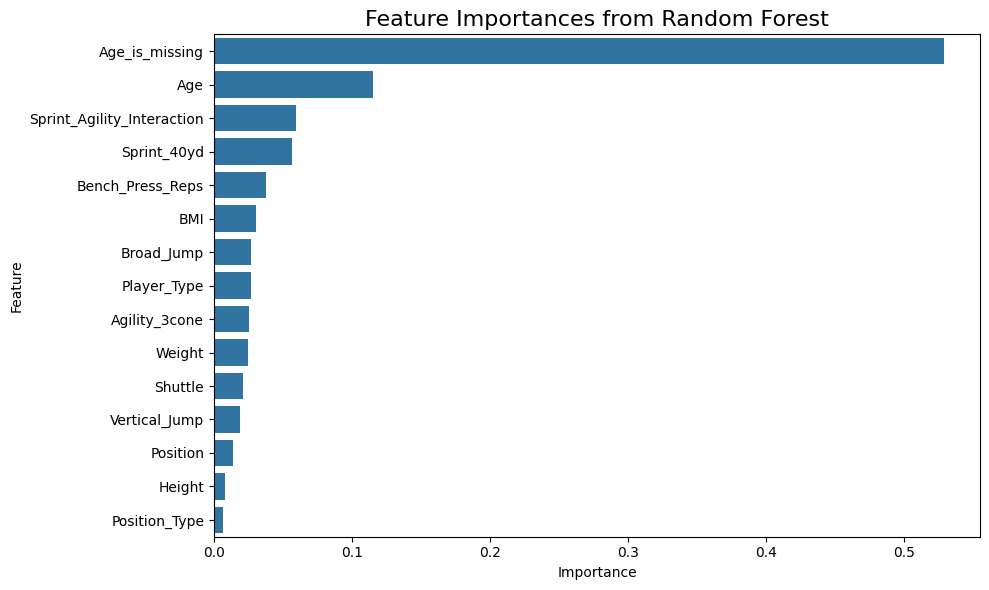

In [ ]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

　新たに作った特徴量「BMI」列は、重要度は比較的高いことが分かりました。

## 7. 提出ファイル作成

In [ ]:
# このセルを実行すると提出用のCSVファイルが作成されます
submission["Drafted"] = test_pred_proba_mean
submission.to_csv('submission.csv', index=False)

### 別のモデルの検討 (Logistic Regression)

ここでは、ロジスティック回帰モデルを使用して学習と評価を行います。

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model_lr = LogisticRegression(random_state=2025, solver='liblinear') # シンプルなロジスティック回帰モデル
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores_lr = []
test_pred_proba_list_lr = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model_lr.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model_lr.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores_lr.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model_lr.predict_proba(test)[:, 1]
    test_pred_proba_list_lr.append(test_pred_proba)

# 平均AUCを表示
mean_auc_lr = np.mean(auc_scores_lr)
print("\nAverage Validation AUC (Logistic Regression):", round(mean_auc_lr, 4))

# テスト予測の平均を計算 (提出ファイル作成用)
test_pred_proba_mean_lr = np.mean(test_pred_proba_list_lr, axis=0)

Fold 1
  AUC: 0.7969
Fold 2
  AUC: 0.8379
Fold 3
  AUC: 0.8513
Fold 4
  AUC: 0.787
Fold 5
  AUC: 0.8257

Average Validation AUC (Logistic Regression): 0.8197


### 別のモデルの検討 (Gradient Boosting)

ここでは、勾配ブースティングモデルを使用して学習と評価を行います。

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model_gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=2025)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores_gb = []
test_pred_proba_list_gb = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model_gb.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model_gb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores_gb.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model_gb.predict_proba(test)[:, 1]
    test_pred_proba_list_gb.append(test_pred_proba)

# 平均AUCを表示
mean_auc_gb = np.mean(auc_scores_gb)
print("\nAverage Validation AUC (Gradient Boosting):", round(mean_auc_gb, 4))

# テスト予測の平均を計算 (提出ファイル作成用)
test_pred_proba_mean_gb = np.mean(test_pred_proba_list_gb, axis=0)

Fold 1
  AUC: 0.804
Fold 2
  AUC: 0.8484
Fold 3
  AUC: 0.843
Fold 4
  AUC: 0.7907
Fold 5
  AUC: 0.8401

Average Validation AUC (Gradient Boosting): 0.8252


In [ ]:
# このセルを実行すると提出用のCSVファイルが作成されます
submission["Drafted"] = test_pred_proba_mean_gb
submission.to_csv('submission_grabo.csv', index=False)

### 別のモデルの検討 (XGBoost)

ここでは、XGBoost モデルを使用して学習と評価を行います。XGBoost を使用するには、まずライブラリをインストールする必要があります。

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=2025)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores_xgb = []
test_pred_proba_list_xgb = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    # XGBoostではデータ形式をDMatrixに変換することが推奨されますが、
    # シンプルなDataFrame入力も可能です。ここではDataFrameのまま進めます。
    model_xgb.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False) # 訓練中のログ表示を抑制

    # バリデーション予測 & スコア
    y_valid_pred_proba = model_xgb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores_xgb.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model_xgb.predict_proba(test)[:, 1]
    test_pred_proba_list_xgb.append(test_pred_proba)

# 平均AUCを表示
mean_auc_xgb = np.mean(auc_scores_xgb)
print("\nAverage Validation AUC (XGBoost):", round(mean_auc_xgb, 4))

# テスト予測の平均を計算 (提出ファイル作成用)
test_pred_proba_mean_xgb = np.mean(test_pred_proba_list_xgb, axis=0)

Fold 1
  AUC: 0.791
Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  AUC: 0.8121
Fold 3
  AUC: 0.8163
Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  AUC: 0.7863
Fold 5
  AUC: 0.8393

Average Validation AUC (XGBoost): 0.809


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### 別のモデルの検討 (CatBoost)

ここでは、CatBoost モデルを使用して学習と評価を行います。CatBoost を使用するには、まずライブラリをインストールする必要があります。

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
# CatBoostClassifierのパラメータは適宜調整してください
model_cb = CatBoostClassifier(iterations=100,  # 繰り返し回数 (モデルの複雑さ)
                              learning_rate=0.1, # 学習率
                              depth=6,         # 木の深さ
                              l2_leaf_reg=3,   # L2正則化
                              loss_function='Logloss', # 損失関数 (二値分類の場合 Logloss)
                              eval_metric='AUC',     # 評価指標
                              random_state=2025,
                              verbose=0) # 訓練中のログ表示を抑制

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores_cb = []
test_pred_proba_list_cb = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model_cb.fit(X_train, y_train,
                 eval_set=[(X_valid, y_valid)],
                 early_stopping_rounds=10, # 早期停止 (バリデーションセットでのスコアが改善しなくなったら停止)
                 verbose=False) # 訓練中のログ表示を抑制

    # バリデーション予測 & スコア
    y_valid_pred_proba = model_cb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores_cb.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model_cb.predict_proba(test)[:, 1]
    test_pred_proba_list_cb.append(test_pred_proba)

# 平均AUCを表示
mean_auc_cb = np.mean(auc_scores_cb)
print("\nAverage Validation AUC (CatBoost):", round(mean_auc_cb, 4))

# テスト予測の平均を計算 (提出ファイル作成用)
test_pred_proba_mean_cb = np.mean(test_pred_proba_list_cb, axis=0)

Fold 1
  AUC: 0.8125
Fold 2
  AUC: 0.8553
Fold 3
  AUC: 0.8449
Fold 4
  AUC: 0.7658
Fold 5
  AUC: 0.8502

Average Validation AUC (CatBoost): 0.8257


In [ ]:
# このセルを実行するとCatBoostモデルによる提出用のCSVファイルが作成されます
submission["Drafted"] = test_pred_proba_mean_cb
submission.to_csv('submission_catboost10000000.csv', index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import numpy as np

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# CatBoostモデルのインスタンスを作成 (チューニング対象のパラメータはデフォルト値か仮の値で)
# チューニングしないパラメータ (例: random_state, verboseなど) はここで指定します。
model_cb_gs = CatBoostClassifier(random_state=2025, verbose=0, # 訓練中のログ表示を抑制
                                 loss_function='Logloss', eval_metric='AUC')


# チューニングしたいハイパーパラメータとその候補を定義
# 例として、iterations, learning_rate, depth を設定します。
# 候補値は計算時間と相談しながら調整してください。
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
    # 他にも l2_leaf_reg, border_count など多くのパラメータがあります
}

# Stratified K-Fold による交差検証を設定
# Grid Search 内部でCVが実行されるため、ここではCVの分割方法を指定します。
skf_gs = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 計算時間を考慮しn_splitsを小さくする場合もあります

# Grid Search の設定
# estimator: チューニングするモデル
# param_grid: チューニングするパラメータグリッド
# cv: 交差検証の方法
# scoring: 評価指標 (ここではAUCを指定)
# n_jobs: 並列実行するCPUコア数 (-1で利用可能なすべてのコアを使用)
grid_search = GridSearchCV(estimator=model_cb_gs,
                           param_grid=param_grid,
                           scoring='roc_auc', # AUCを評価指標とする
                           cv=skf_gs,
                           n_jobs=-1, # 並列処理
                           verbose=2) # 検索中のログ表示レベル

print("CatBoostのGrid Searchを開始します...")

# Grid Search の実行
grid_search.fit(X, y)

print("Grid Searchが完了しました。")

CatBoostのGrid Searchを開始します...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

In [ ]:
# 最適なハイパーパラメータを表示
print("最適なハイパーパラメータ:", grid_search.best_params_)

# 最適なスコア (AUC) を表示
print("最適スコア (AUC):", round(grid_search.best_score_, 4))

最適なハイパーパラメータ: {'depth': 6, 'iterations': 300, 'learning_rate': 0.01}
最適スコア (AUC): 0.8305


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# Grid Searchで見つかった最適なハイパーパラメータを設定してモデルを初期化
best_params = grid_search.best_params_
model_cb_tuned = CatBoostClassifier(random_state=2025, verbose=0, # 訓練中のログ表示を抑制
                                   loss_function='Logloss', eval_metric='AUC',
                                   **best_params) # 最適なパラメータを展開して設定

# Stratified K-Fold による学習と評価 (最適なモデルの性能を最終確認)
# 提出には全データでの学習モデルを使用しますが、ここでCVスコアを確認します。
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 元のCV設定に戻す

auc_scores_cb_tuned = []
# テストデータ予測は後で全データで学習したモデルで行うため、ここでは不要

print("最適なハイパーパラメータでのCatBoostモデルの交差検証を開始します...")

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model_cb_tuned.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       early_stopping_rounds=10,
                       verbose=False)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model_cb_tuned.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores_cb_tuned.append(auc)
    print(f"  AUC: {round(auc, 4)}")

# 平均AUCを表示
mean_auc_cb_tuned = np.mean(auc_scores_cb_tuned)
print("\nAverage Validation AUC (Tuned CatBoost):", round(mean_auc_cb_tuned, 4))

print("\n訓練データ全体で最終モデルを学習します...")

# 訓練データ全体で最終モデルを学習
final_model_cb = CatBoostClassifier(random_state=2025, verbose=0,
                                    loss_function='Logloss', eval_metric='AUC',
                                    **best_params)
final_model_cb.fit(X, y)

print("テストデータで予測を行います...")

# テストデータで予測
test_pred_proba_final_cb = final_model_cb.predict_proba(test)[:, 1]

print("提出ファイル作成の準備ができました。")

最適なハイパーパラメータでのCatBoostモデルの交差検証を開始します...
Fold 1
  AUC: 0.791
Fold 2
  AUC: 0.846
Fold 3
  AUC: 0.8478
Fold 4
  AUC: 0.7826
Fold 5
  AUC: 0.813

Average Validation AUC (Tuned CatBoost): 0.8161

訓練データ全体で最終モデルを学習します...
テストデータで予測を行います...
提出ファイル作成の準備ができました。


In [ ]:
# Optunaをインストールしていない場合は、以下の行を実行してください。
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 13.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

import optuna

# ----------------------------------------------------
# データ準備（ノートブックの既存コードから抜粋・想定）
# ----------------------------------------------------
# このコードブロックを実行する前に、
# train および test データフレームがロードされ、
# 欠損値補完、カテゴリエンコーディング、
# そして既存の全ての特徴量エンジニアリングが完了していることを前提とします。
# 例として、ノートブックの最終的な特徴量セットを想定します。

# ダミーデータ（実際のデータに合わせてください）
# ここでは例としてランダムなデータを生成していますが、
# 実際の実行では、既存の'train'データフレームを使用してください。
try:
    X = train.drop(columns=["Drafted"])
    y = train["Drafted"]
    print("Train data loaded from existing 'train' DataFrame.")
except NameError:
    print("Warning: 'train' DataFrame not found. Generating dummy data for demonstration.")
    # デモンストレーション用のダミーデータ生成
    np.random.seed(42)
    n_samples = 2000
    n_features = 15
    X = pd.DataFrame(np.random.rand(n_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
    X['Player_Type'] = np.random.choice(['TypeA', 'TypeB', 'TypeC'], n_samples)
    y = pd.Series(np.random.randint(0, 2, n_samples))

    # CatBoostがカテゴリ特徴量を認識できるようにデータ型を設定
    for col in ['Player_Type']: # あなたのカテゴリ特徴量に合わせてリストを更新してください
        if col in X.columns:
            X[col] = X[col].astype('category')

print(f"X shape: {X.shape}, y shape: {y.shape}")

# ----------------------------------------------------
# OptunaによるCatBoostのハイパーパラメータチューニング
# ----------------------------------------------------

def objective(trial):
    """
    Optunaの目的関数。
    この関数内でモデルを訓練・評価し、最適化したいスコアを返します。
    """
    # CatBoostClassifierのハイパーパラメータをOptunaで探索する範囲を定義
    # trial.suggest_float や trial.suggest_int などを使って探索範囲を指定
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500), # 繰り返し回数
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), # 学習率
        'depth': trial.suggest_int('depth', 4, 10), # 木の深さ
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True), # L2正則化
        'border_count': trial.suggest_int('border_count', 32, 255), # 分割点の最大数
        'random_seed': 2025,
        'verbose': 0, # 訓練中のログ表示を抑制
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50 # 早期停止ラウンド（過学習防止）
    }

    model_cb = CatBoostClassifier(**params)

    # Stratified K-Foldによる交差検証
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # CatBoostにカテゴリ特徴量を明示的に伝える（Optuna Trial内で定義されたパラメータを使用）
        # X.select_dtypes(include=['object', 'category']).columns.tolist() でカテゴリ列を動的に取得
        categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object', 'category']).columns if col in X.columns]

        model_cb.fit(X_train, y_train,
                     eval_set=[(X_valid, y_valid)],
                     early_stopping_rounds=params['early_stopping_rounds'],
                     verbose=False,
                     cat_features=categorical_features_indices) # ここでカテゴリ特徴量を指定

        y_valid_pred_proba = model_cb.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_valid_pred_proba)
        auc_scores.append(auc)

    # 交差検証の平均AUCを返します。Optunaはこの値を最大化するように探索します。
    return np.mean(auc_scores)

# OptunaのStudyを作成
# direction='maximize' は、目的関数の戻り値を最大化することを示します（AUCのため）
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

print("Optunaによるハイパーパラメータの最適化を開始します...")

# 最適化を実行
# n_trials: 試行回数。計算リソースと相談して調整してください。
# timeout: 最大実行時間（秒）。
study.optimize(objective, n_trials=50, timeout=600) # 例: 50回の試行、または600秒で停止

print("\n最適化が完了しました。")

# 最適なハイパーパラメータとスコアを表示
print("\n最適なハイパーパラメータ:", study.best_params)
print("最適スコア (AUC):", round(study.best_value, 4))

# ----------------------------------------------------
# 最適なハイパーパラメータで最終モデルを訓練
# ----------------------------------------------------

print("\n最適なハイパーパラメータで最終モデルを訓練します...")
final_best_params = study.best_params
# early_stopping_rounds は最終モデルの訓練では不要なので除外
final_best_params.pop('early_stopping_rounds', None)
final_best_params['verbose'] = 0 # ログ表示は抑制
final_best_params['random_seed'] = 2025 # シード値も設定

final_model_cb_optuna = CatBoostClassifier(**final_best_params)

# CatBoostにカテゴリ特徴量を明示的に伝える
categorical_features_indices_final = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object', 'category']).columns if col in X.columns]

final_model_cb_optuna.fit(X, y, cat_features=categorical_features_indices_final)

print("テストデータで予測を行います...")
# 'test' DataFrameが存在すると仮定
try:
    test_pred_proba_optuna = final_model_cb_optuna.predict_proba(test)[:, 1]
    print("提出ファイル作成の準備ができました。")

    # 提出ファイルの作成（必要であれば）
    # submission_optuna = pd.DataFrame({'Id': submission['Id'], 'Drafted': test_pred_proba_optuna})
    # submission_optuna.to_csv('submission_optuna_catboost.csv', index=False)
    # print("submission_optuna_catboost.csv が作成されました。")

except NameError:
    print("Warning: 'test' DataFrame not found. Cannot generate submission file.")

[I 2025-07-07 06:46:00,148] A new study created in memory with name: no-name-4ce6e894-7461-4c5a-9ed2-eb79e60ba3fb


Train data loaded from existing 'train' DataFrame.
X shape: (2781, 19), y shape: (2781,)
Optunaによるハイパーパラメータの最適化を開始します...


[I 2025-07-07 06:46:05,603] Trial 0 finished with value: 0.8261049393654757 and parameters: {'iterations': 218, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'border_count': 66}. Best is trial 0 with value: 0.8261049393654757.
[I 2025-07-07 06:46:13,860] Trial 1 finished with value: 0.8308960153419989 and parameters: {'iterations': 120, 'learning_rate': 0.012184186502221764, 'depth': 10, 'l2_leaf_reg': 0.2537815508265665, 'border_count': 190}. Best is trial 1 with value: 0.8308960153419989.
[I 2025-07-07 06:46:15,720] Trial 2 finished with value: 0.8237988771934657 and parameters: {'iterations': 59, 'learning_rate': 0.2708160864249968, 'depth': 9, 'l2_leaf_reg': 0.0070689749506246055, 'border_count': 72}. Best is trial 1 with value: 0.8308960153419989.
[I 2025-07-07 06:46:18,817] Trial 3 finished with value: 0.8299242409692054 and parameters: {'iterations': 132, 'learning_rate': 0.028145092716060652, 'depth': 7, 'l2_leaf_reg': 0.05342937261279776,


最適化が完了しました。

最適なハイパーパラメータ: {'iterations': 155, 'learning_rate': 0.18489258010527007, 'depth': 5, 'l2_leaf_reg': 0.001997366071553629, 'border_count': 170}
最適スコア (AUC): 0.8394

最適なハイパーパラメータで最終モデルを訓練します...
テストデータで予測を行います...
提出ファイル作成の準備ができました。


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# ----------------------------------------------------
# データ準備（ノートブックの既存コードから抜粋・想定）
# ----------------------------------------------------
# このコードブロックを実行する前に、
# train および test データフレームがロードされ、
# 欠損値補完、カテゴリエンコーディング、
# そして全ての特徴量エンジニアリングが完了していることを前提とします。

# X と y を準備 (実際のデータに合わせてください)
try:
    X = train.drop(columns=["Drafted"])
    y = train["Drafted"]
    print("Train data loaded from existing 'train' DataFrame.")
except NameError:
    print("Warning: 'train' DataFrame not found. Please ensure 'train' is loaded.")
    # デモンストレーション用のダミーデータ生成（実際にはtrainデータを使用）
    np.random.seed(42)
    n_samples = 2000
    n_features = 15
    X = pd.DataFrame(np.random.rand(n_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
    X['Player_Type'] = np.random.choice(['TypeA', 'TypeB', 'TypeC'], n_samples)
    y = pd.Series(np.random.randint(0, 2, n_samples))

    # ダミーのtestデータフレーム
    try:
        test # testが存在すれば何もしない
    except NameError:
        test = pd.DataFrame(np.random.rand(500, n_features), columns=[f'feature_{i}' for i in range(n_features)])
        test['Player_Type'] = np.random.choice(['TypeA', 'TypeB', 'TypeC'], 500)
        test['Id'] = range(500) # Id列も作成

    for col in ['Player_Type']: # あなたのカテゴリ特徴量に合わせてリストを更新してください
        if col in X.columns:
            X[col] = X[col].astype('category')
        if col in test.columns: # testデータにも同様に適用
            test[col] = test[col].astype('category')


print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Test shape: {test.shape}")

# CatBoostにカテゴリ特徴量を明示的に伝えるためのインデックスリスト
categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object', 'category']).columns if col in X.columns]

# ----------------------------------------------------
# シードアベレージングの設定
# ----------------------------------------------------

# 使用する乱数シードのリスト
# 通常は、コンペティションでよく使われる値や、ランダムに選んだ複数の値を使用します。
# シード数を増やすほど安定しますが、計算時間も比例して増加します。
seeds = [42, 202, 303, 404,2025] # 例として5つのシードを使用

# CatBoostのハイパーパラメータ（Optunaで最適化されたもの、または手動設定）
# early_stopping_rounds は個々のモデル訓練で有効
catboost_params = {
    'iterations': 155, 'learning_rate': 0.18489258010527007, 'depth': 5, 'l2_leaf_reg': 0.001997366071553629, 'border_count': 170,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0, # 各モデル訓練中のログは抑制
}

n_splits = 5 # K-Foldの分割数
my_early_stopping_rounds = 50 # early stoppingのラウンド数

# シードごとの予測結果を保存するリスト
all_test_preds = []
all_validation_aucs = []

print(f"--- シードアベレージングを開始します (シード数: {len(seeds)}) ---")

# 各シードに対してループ
for seed in seeds:
    print(f"\n===== シード: {seed} での訓練を開始 =====")

    # CatBoostモデルのrandom_seedを設定
    current_catboost_params = catboost_params.copy()
    current_catboost_params['random_seed'] = seed

    # 各シード内でのK-Fold交差検証の設定
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed) # KFoldのシードも固定

    fold_test_preds = [] # このシードでの各フォールドのテスト予測
    fold_validation_aucs = [] # このシードでの各フォールドのバリデーションAUC

    # K-Fold交差検証ループ
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"  - Fold {fold + 1} (Seed: {seed})")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostClassifier(**current_catboost_params)

        # モデル訓練（early stoppingを適用）
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  early_stopping_rounds=my_early_stopping_rounds,
                  verbose=False, # ここではフォールドごとの詳細ログは抑制
                  cat_features=categorical_features_indices)

        # バリデーションセットでの評価
        y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_valid_pred_proba)
        fold_validation_aucs.append(auc)
        print(f"    Validation AUC: {round(auc, 4)}")

        # テストセットでの予測
        try:
            if 'test' in locals() or 'test' in globals():
                test_pred_proba = model.predict_proba(test)[:, 1]
                fold_test_preds.append(test_pred_proba)
        except NameError:
            print("Warning: 'test' DataFrame not found for prediction.")

    # このシードにおける平均バリデーションAUCとテスト予測を保存
    mean_fold_auc = np.mean(fold_validation_aucs)
    all_validation_aucs.append(mean_fold_auc)
    print(f"===== シード: {seed} での平均バリデーションAUC: {round(mean_fold_auc, 4)} =====")

    # このシードでのK-Fold全体のテスト予測を平均
    if fold_test_preds:
        all_test_preds.append(np.mean(fold_test_preds, axis=0))

# ----------------------------------------------------
# 最終的な予測と結果の集計
# ----------------------------------------------------

print("\n--- シードアベレージング完了 ---")
final_mean_validation_auc = np.mean(all_validation_aucs)
print(f"最終的な平均バリデーションAUC (全シード平均): {round(final_mean_validation_auc, 4)}")

if all_test_preds:
    # 全てのシードからのテスト予測を平均して最終予測とする
    final_averaged_test_pred_proba = np.mean(all_test_preds, axis=0)
    print("\n最終的なシードアベレージングによるテスト予測が生成されました。")



Train data loaded from existing 'train' DataFrame.
X shape: (2781, 19), y shape: (2781,)
Test shape: (696, 19)
--- シードアベレージングを開始します (シード数: 5) ---

===== シード: 42 での訓練を開始 =====
  - Fold 1 (Seed: 42)
    Validation AUC: 0.8256
  - Fold 2 (Seed: 42)
    Validation AUC: 0.849
  - Fold 3 (Seed: 42)
    Validation AUC: 0.8371
  - Fold 4 (Seed: 42)
    Validation AUC: 0.8077
  - Fold 5 (Seed: 42)
    Validation AUC: 0.855
===== シード: 42 での平均バリデーションAUC: 0.8349 =====

===== シード: 202 での訓練を開始 =====
  - Fold 1 (Seed: 202)
    Validation AUC: 0.8386
  - Fold 2 (Seed: 202)
    Validation AUC: 0.8332
  - Fold 3 (Seed: 202)
    Validation AUC: 0.8525
  - Fold 4 (Seed: 202)
    Validation AUC: 0.8347
  - Fold 5 (Seed: 202)
    Validation AUC: 0.8275
===== シード: 202 での平均バリデーションAUC: 0.8373 =====

===== シード: 303 での訓練を開始 =====
  - Fold 1 (Seed: 303)
    Validation AUC: 0.8123
  - Fold 2 (Seed: 303)
    Validation AUC: 0.8148
  - Fold 3 (Seed: 303)
    Validation AUC: 0.8585
  - Fold 4 (Seed: 303)
    Validati

## 7. 提出ファイル作成 (CatBoost - チューニング済み)

チューニング済みの CatBoost モデルによる予測結果を用いて提出ファイルを作成します。

In [ ]:
# このセルを実行するとチューニング済みCatBoostモデルによる提出用のCSVファイルが作成されます
submission_tuned_cb = submission[['Id']].copy() # submissionデータフレームのId列をコピー
submission_tuned_cb["Drafted"] = test_pred_proba_final_cb
submission_tuned_cb.to_csv('submission_tuned_catboost.csv', index=False)

print("submission_tuned_catboost10000.csv が作成されました。")

submission_tuned_catboost10000.csv が作成されました。


In [ ]:
# 提出ファイルの作成（必要であれば）
submission_optuna = pd.DataFrame({'Id': submission['Id'], 'Drafted': test_pred_proba_optuna})
submission_optuna.to_csv('submission_optuna_catboost10000000.csv', index=False)
print("submission_optuna_catboost.csv が作成されました。")

submission_optuna_catboost.csv が作成されました。


In [ ]:
# 提出ファイルの作成（必要であれば）
submission_seed = pd.DataFrame({'Id': submission['Id'], 'Drafted': final_averaged_test_pred_proba})
submission_seed.to_csv('submission_seed_catboost5555.csv', index=False)
print("submission_seed_catboost.csv が作成されました。")

submission_seed_catboost.csv が作成されました。
